[*********************100%***********************]  1 of 1 completed
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 100)          40800     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
 228/1282 [====>.........................] - ETA: 26s - loss: 0.0012

KeyboardInterrupt: 

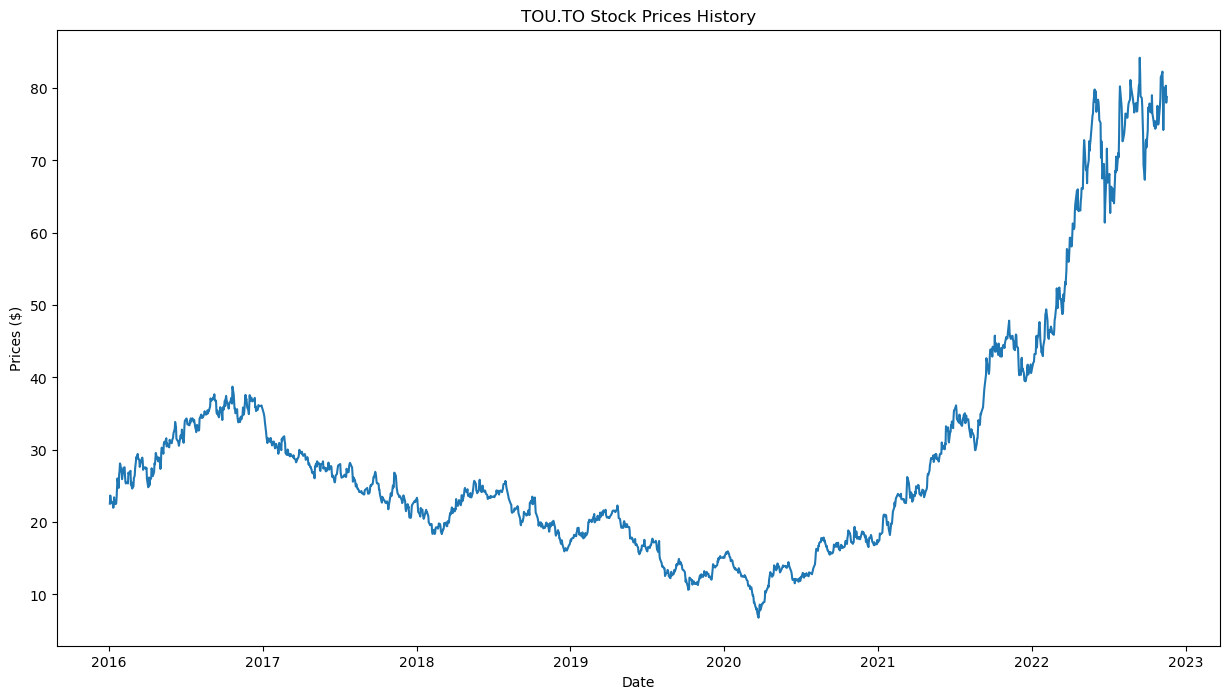

In [19]:
# Package Plan
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import *


# 1. Acquire Stock Data Using API
stock_name = 'TOU.TO'
start_date = '2016-01-01'
end_date = '2022-11-18'
stock_data = yf.download(f'{stock_name}', start= start_date, end=end_date)
stock_data.head()



# 2. Visualize Historical Stock Price
plt.figure(figsize=(15, 8))
plt.title(f'{stock_name} Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
# plt.show()



# 3. Prepare Training Data Set
close_prices = stock_data['Close']
#print('close_prices type: ', type(close_prices))
values = close_prices.values
# We are going to extract 80% of the closing prices from our acquired stock data as our training set
training_data_len = math.ceil(len(values) * 0.8)

# Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1.
# We also reshape our normalized data into a two-dimensional array.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []
window_size = 100

# Create a 60-days window of historical prices (i-60) as our feature data (x_train)
# the following 60-days window as label data (y_train)
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i - window_size:i, 0])
    y_train.append(train_data[i, 0])

# Convert the feature data (x_train) and label data (y_train) into Numpy array
# Numpy array is the data format accepted by the Tensorflow when training a neural network model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(x_train)
# print(y_train)

# 4. Prepare Test Data Set
test_data = scaled_data[training_data_len-window_size: , : ]

# create feature data (x_test) and label data (y_test)from our test set
x_test = []
y_test = values[training_data_len:]
for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

# Reshape again the x_test and y_test into a three-dimensional array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 5. Setup LSTM Network Architecture
# Define a Sequential model which consists of a linear stack of layers
model = keras.Sequential()

# Add a LSTM layer by giving it 100 network units.
# Set the return_sequence to true so that the output of the layer will be another sequence of the same length
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another LSTM layer with also 100 network units.
# But we set the return_sequence to false for this time to only return the last output in the output sequence.
model.add(layers.LSTM(100, return_sequences=False))

# Add a densely connected neural network layer with 25 network units
model.add(layers.Dense(25))

#At last, add a densely connected layer that specifies the output of 1 network unit
model.add(layers.Dense(1))
# Show summary
model.summary()



# 6. Train LSTM Model
# Adopt “adam” optimizer and set the mean square error as loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model by fitting it with the training set.
# We can try with batch_size of 1 and run the training for 3 epochs
hist = model.fit(x_train, y_train, batch_size= 1, epochs=3, verbose = 1)
model.save('LSTM.h5', hist)


# 7. Evaluate Model with RMSE
predictions = model.predict(x_test)
# Use the inverse_transform method to denormalize the predicted stock prices.
predictions_inversed = scaler.inverse_transform(predictions)
# Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test)
rmse = np.sqrt(np.mean(predictions_inversed - y_test)**2)
print('Model RMSE: ', rmse)


# # 8. Visualize Predicted Price
# data = stock_data.filter(['Close'])
# train = data[:training_data_len]
# validation = data[training_data_len:]
# validation['Predictions'] = predictions
# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date')
# plt.ylabel('Close Price USD ($)')
# plt.plot(train)
# plt.plot(validation[['Close', 'Predictions']])
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()



<AxesSubplot:title={'center':'ENB.TO '}>

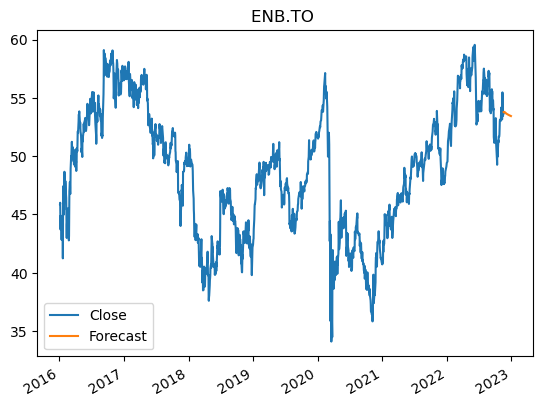

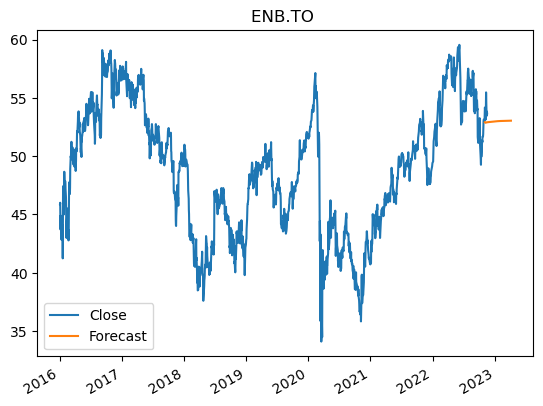

In [13]:


# generate the multi-step forecasts
def multi_step_forecasts(model, close_prices, x, y, n_past, n_future):

    x_past = x[-n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[-n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame

    df_past = pd.DataFrame(
        data=close_prices
    )

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=close_prices.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

#print(data)
model = load_model('LSTM.h5')

# 1. Acquire Stock Data Using API
stock_name = 'MFC.TO '
start_date = '2016-01-01'
end_date = '2022-11-18'
stock_data = yf.download(f'{stock_name}', start= start_date, end=end_date)
stock_data.head()

# 2. Visualize Historical Stock Price
plt.figure(figsize=(15, 8))
plt.title(f'{stock_name} Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
# plt.show()

# 3. Prepare Training Data Set
close_prices = stock_data['Close']
#print('close_prices type: ', type(close_prices))
values = close_prices.values
# We are going to extract 80% of the closing prices from our acquired stock data as our training set
training_data_len = math.ceil(len(values) * 0.8)

# Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1.
# We also reshape our normalized data into a two-dimensional array.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []
window_size = 100

# Create a 60-days window of historical prices (i-60) as our feature data (x_train)
# the following 60-days window as label data (y_train)
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i - window_size:i, 0])
    y_train.append(train_data[i, 0])

# Convert the feature data (x_train) and label data (y_train) into Numpy array
# Numpy array is the data format accepted by the Tensorflow when training a neural network model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(x_train)
# print(y_train)

# 4. Prepare Test Data Set
test_data = scaled_data[training_data_len-window_size: , : ]

# create feature data (x_test) and label data (y_test)from our test set
x_test = []
y_test = values[training_data_len:]
for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

# Reshape again the x_test and y_test into a three-dimensional array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# forecast the next 30 days
df1 = multi_step_forecasts(model, close_prices, x_test, predictions,n_past=0, n_future=30)
df1.plot(title=stock_name)

# forecast the last 20 days and the next 30 days
df2 = multi_step_forecasts(model, close_prices, x_test, predictions, n_past=10, n_future=100)
df2.plot(title=stock_name)


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'SU.TO '}>

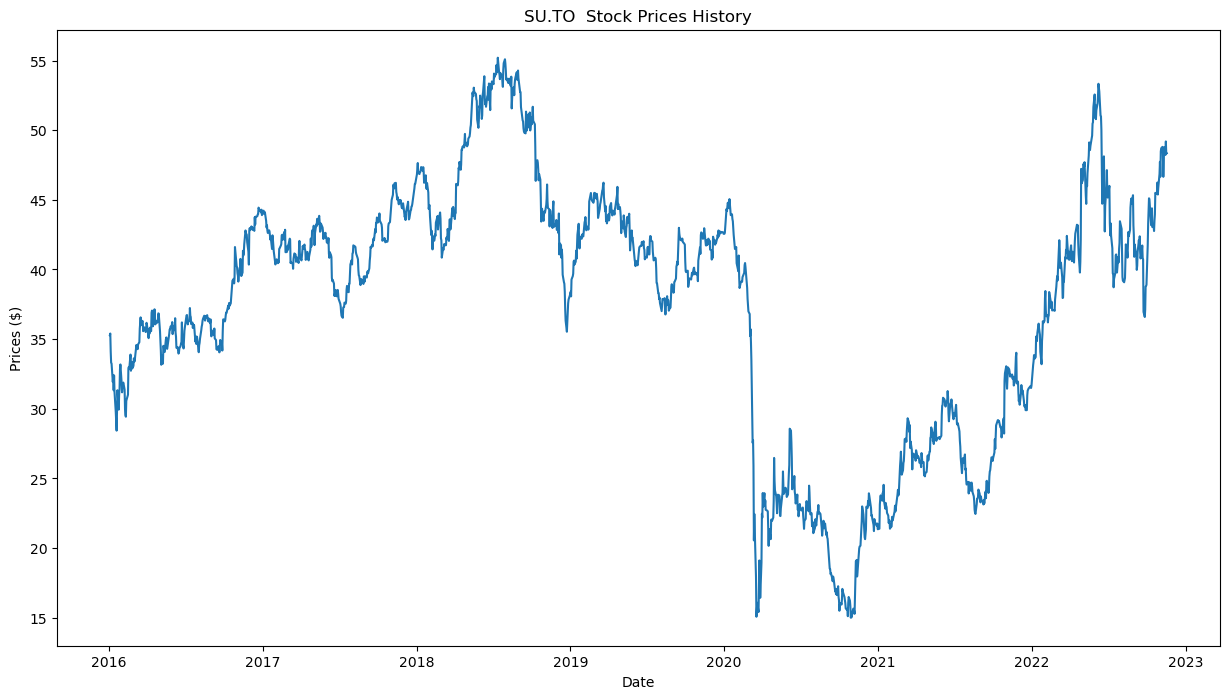

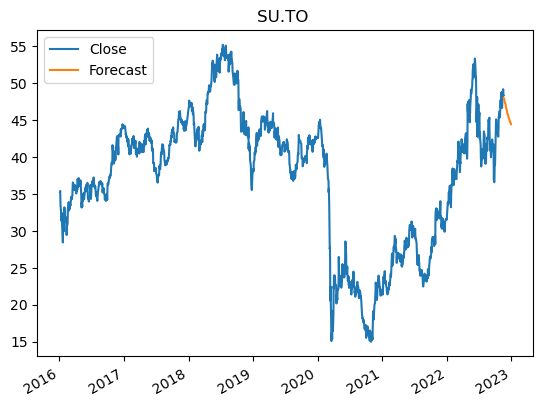

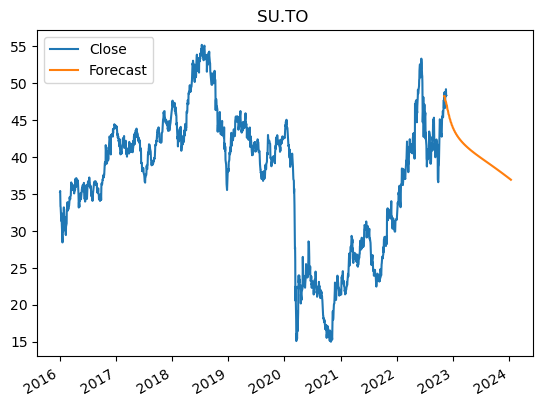

In [17]:
# Package Plan
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import *

# generate the multi-step forecasts
def multi_step_forecasts(model, close_prices, x, y, n_past, n_future):

    x_past = x[-n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[-n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame

    df_past = pd.DataFrame(
        data=close_prices
    )

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=close_prices.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

#print(data)
model = load_model('LSTM_3.h5')

# 1. Acquire Stock Data Using API
stock_name = 'SU.TO '
start_date = '2016-01-01'
end_date = '2022-11-18'
stock_data = yf.download(f'{stock_name}', start= start_date, end=end_date)
stock_data.head()

# 2. Visualize Historical Stock Price
plt.figure(figsize=(15, 8))
plt.title(f'{stock_name} Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
# plt.show()

# 3. Prepare Training Data Set
close_prices = stock_data['Close']
#print('close_prices type: ', type(close_prices))
values = close_prices.values

# Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1.
# We also reshape our normalized data into a two-dimensional array.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

window_size = 100

# 4. Prepare Test Data Set
test_data = scaled_data

# create feature data (x_test) and label data (y_test)from our test set
x_test = []
y_test = scaled_data
for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

# Reshape again the x_test and y_test into a three-dimensional array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 7. Evaluate Model with RMSE
# predictions = model.predict(x_test)

# forecast the next 30 days
df1 = multi_step_forecasts(model, close_prices, x_test, y_test,n_past=0, n_future=30)
df1.plot(title=stock_name)

# forecast the last 20 days and the next 30 days
df2 = multi_step_forecasts(model, close_prices, x_test, y_test, n_past=10, n_future=300)
df2.plot(title=stock_name)